In [154]:
import math
import os
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from experiment import preliminary_setup

In [155]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [242]:
def get_summary(experiment):
    grid = pd.read_csv(os.path.join(KWARGS['misc_directory'],f'{experiment}_grid.csv'))
    summary = pd.read_csv(os.path.join(KWARGS['summary_directory'],f'{experiment}.csv'))
    summary = grid.merge(summary,on='simulation_id',how='inner')

    # score summary
    columns = [
        'net_electricity_consumption_sum',
        'net_electricity_consumption_emission_sum',
        'net_electricity_consumption_price_sum',
        'net_electricity_consumption_without_storage_sum',
        'net_electricity_consumption_emission_without_storage_sum',
        'net_electricity_consumption_price_without_storage_sum',
        'reward_sum',
    ]
    score_summary = summary.groupby(['group','simulation_id','episode'])[columns].sum().reset_index()
    score_summary['consumption_score'] = score_summary['net_electricity_consumption_sum']\
        /score_summary['net_electricity_consumption_without_storage_sum']
    score_summary['price_score'] = score_summary['net_electricity_consumption_price_sum']\
        /score_summary['net_electricity_consumption_price_without_storage_sum']
    score_summary['emission_score'] = score_summary['net_electricity_consumption_emission_sum']\
        /score_summary['net_electricity_consumption_emission_without_storage_sum']
    score_columns = ['consumption_score','price_score','emission_score']
    score_summary = score_summary.groupby(['group','episode'])[score_columns + ['reward_sum']].mean().reset_index()
    score_summary['average_score'] = score_summary[score_columns].mean(axis=1)
    score_summary['average_price_and_emission_score'] = score_summary[['price_score','emission_score']].mean(axis=1)

    return grid, summary, score_summary

def plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None):
    row_count = 1
    column_count = 3
    ylim = (
        plot_data[['average_price_and_emission_score','price_score','emission_score']].min().min(),
        plot_data[['average_price_and_emission_score','price_score','emission_score']].max().max()
    )

    for fig_names, type_group in plot_data.groupby(fig_groupby_columns):
        fig, axs = plt.subplots(row_count,column_count,figsize=(4*column_count,2.0*row_count),sharey=True)
        
        for ax_names, simulation_id_group in type_group.groupby(ax_groupby_columns):
            if round_number:
                label = str(tuple([round(n,round_number) for n in ax_names]))
            else:
                label = str(ax_names)

            simulation_id_group = simulation_id_group.sort_values('episode')

            # cost
            x, y = simulation_id_group['episode'], simulation_id_group['price_score']
            axs[0].plot(x,y,label=label)
            axs[0].set_title('Price')

            # carbon_emission
            x, y = simulation_id_group['episode'], simulation_id_group['emission_score']
            axs[1].plot(x,y,label=label)
            axs[1].set_title('Carbon emission')

            # average
            x, y = simulation_id_group['episode'], simulation_id_group['average_price_and_emission_score']
            axs[2].plot(x,y,label=label)
            axs[2].set_title('Average')

        for i, ax in enumerate(fig.axes):
            ax.set_xlabel('Episode')
            ax.set_ylim(ylim)
            ax.axhline(1.0,color='black',linestyle='--')

            if i == 0:
                ax.legend(
                    bbox_to_anchor=(0.5,-0.1),
                    loc='upper center', 
                    bbox_transform=fig.transFigure,
                    framealpha=0,
                    ncol=7
                )
            else:
                pass
        
        fig.suptitle(f'{fig_names}',y=1.10)
        plt.show()

# Reward Design

In [237]:
reward_design_grid, reward_design_summary, reward_design_score_summary = get_summary('reward_design')
reward_design_grid['e'] = reward_design_grid['exponent']
reward_design_grid['w_1'] = reward_design_grid['weight']
reward_design_grid['w_2'] = 1.0 - reward_design_grid['weight']
metadata = reward_design_grid[['group','type','e','w_1','w_2']].drop_duplicates()
reward_design_score_summary = metadata.merge(reward_design_score_summary,on='group',how='left')

# ordered average score by last episode 
display(reward_design_score_summary[reward_design_score_summary['episode']==9][[
    'group','type','e','w_1','w_2','episode',
    'average_score','average_price_and_emission_score',
    'price_score','emission_score','consumption_score',
]].sort_values('average_price_and_emission_score'))

,group,type,e,w_1,w_2,episode,average_score,average_price_and_emission_score,price_score,emission_score,consumption_score
269,20,reward.AdditiveSolarPenaltyReward,1,1.0,0.0,9,0.959991,0.939641,0.866921,1.012361,1.000693
209,17,reward.AdditiveSolarPenaltyReward,1,0.5,0.5,9,0.985213,0.977109,0.926961,1.027258,1.001421
249,19,reward.AdditiveSolarPenaltyReward,1,0.8,0.2,9,0.985374,0.977459,0.922564,1.032354,1.001203
229,18,reward.AdditiveSolarPenaltyReward,1,0.6,0.4,9,0.994329,0.990923,0.943874,1.037972,1.001141
189,16,reward.AdditiveSolarPenaltyReward,1,0.4,0.6,9,0.994658,0.991391,0.954299,1.028484,1.001192
279,27,reward.AdditiveSolarPenaltyReward,2,1.0,0.0,9,0.995295,0.992905,0.862829,1.122980,1.000077
239,25,reward.AdditiveSolarPenaltyReward,2,0.6,0.4,9,1.001193,1.001450,0.884423,1.118478,1.000679
219,24,reward.AdditiveSolarPenaltyReward,2,0.5,0.5,9,1.003352,1.004512,0.885626,1.123398,1.001032
9,0,reward.AdditiveReward,1,0.0,1.0,9,1.006486,1.009225,0.991528,1.026922,1.001008
169,15,reward.AdditiveSolarPenaltyReward,1,0.2,0.8,9,1.007562,1.010748,0.979395,1.042102,1.001190


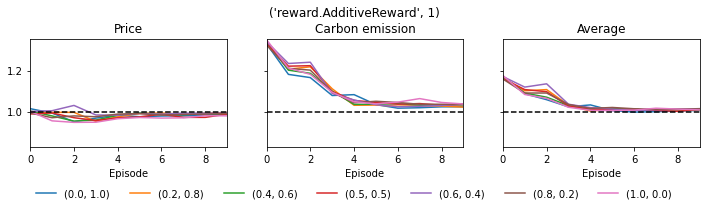

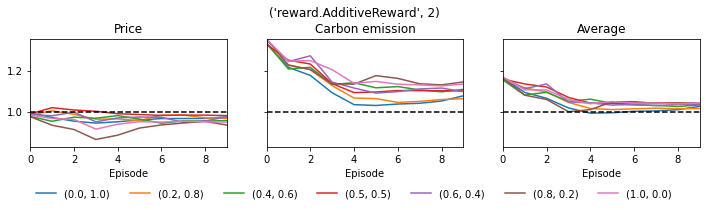

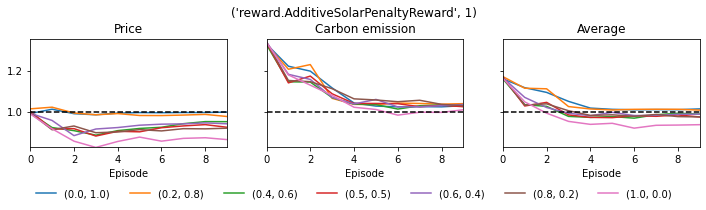

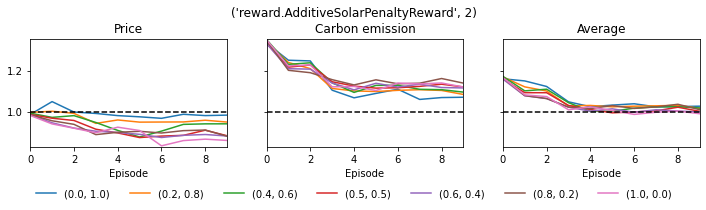

In [243]:
# score trajectory
plot_data = reward_design_score_summary.copy()
fig_groupby_columns = ['type','e']
ax_groupby_columns = ['w_1','w_2']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=1)

# Hyperparameter Design

In [248]:
hyperparameter_design_grid, hyperparameter_design_summary, hyperparameter_design_score_summary = get_summary('hyperparameter_design')
metadata = hyperparameter_design_grid[['group','discount','tau','lr']].drop_duplicates()
hyperparameter_design_score_summary = metadata.merge(hyperparameter_design_score_summary,on='group',how='left')

# ordered average score by last episode 
display(hyperparameter_design_score_summary[hyperparameter_design_score_summary['episode']==9][[
    'group','discount','tau','lr','episode','reward_sum',
    'average_score','average_price_and_emission_score',
    'price_score','emission_score','consumption_score',
]].sort_values('reward_sum',ascending=False))

,group,discount,tau,lr,episode,reward_sum,average_score,average_price_and_emission_score,price_score,emission_score,consumption_score
79,20,0.99,0.0005,0.0500,9,-2965.675686,1.004136,1.005952,1.000813,1.011090,1.000503
229,8,0.90,0.0500,0.0500,9,-2972.538191,1.003030,1.003854,0.994454,1.013255,1.001383
169,2,0.90,0.0005,0.0500,9,-2978.040464,1.004994,1.007164,0.999247,1.015080,1.000655
59,22,0.99,0.0050,0.0050,9,-2978.518676,1.004951,1.007129,0.998544,1.015714,1.000595
109,16,0.95,0.0500,0.0050,9,-2983.983542,1.005640,1.008053,0.998678,1.017428,1.000812
179,3,0.90,0.0050,0.0005,9,-2986.911329,1.000211,0.999952,0.980337,1.019566,1.000730
269,7,0.90,0.0500,0.0050,9,-2987.623696,1.006821,1.009864,1.001532,1.018197,1.000734
19,26,0.99,0.0500,0.0500,9,-2991.151997,1.007093,1.010411,1.001910,1.018911,1.000457
119,15,0.95,0.0500,0.0005,9,-2994.990704,0.991242,0.987148,0.952965,1.021331,0.999432
259,11,0.95,0.0005,0.0500,9,-2998.918311,0.990124,0.985604,0.950678,1.020530,0.999165


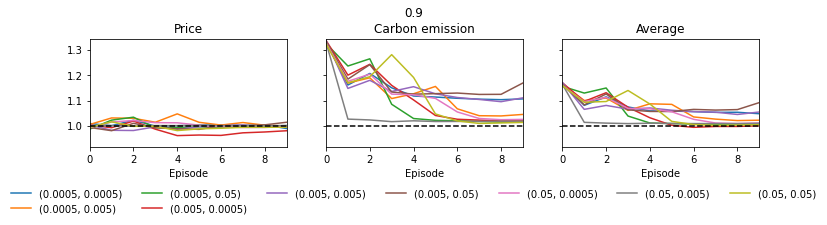

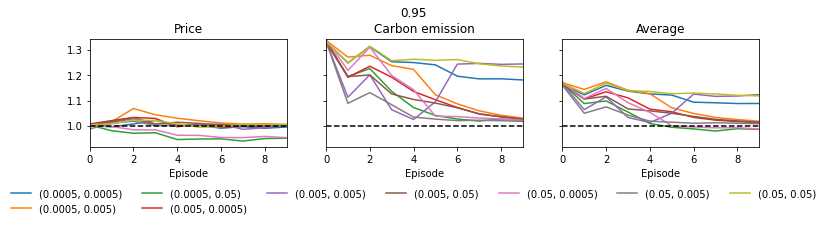

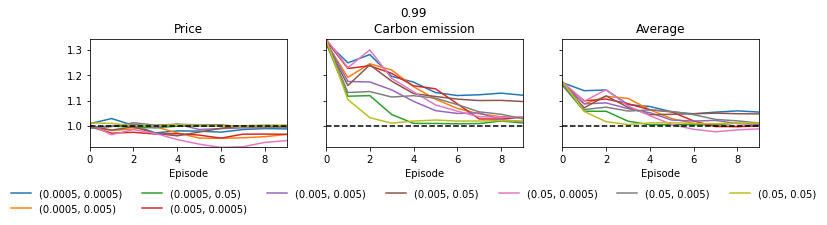

In [245]:
# score trajectory
plot_data = hyperparameter_design_score_summary.copy()
fig_groupby_columns = ['discount']
ax_groupby_columns = ['tau','lr']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None)

In [ ]:
# reward trajectory

# RBC Validation

In [109]:
# RBC Validation
# read actual battery consumption
battery_data = pd.read_csv(os.path.join(misc_directory,'battery_electricity_consumption.csv'))
battery_data.columns = ['timestamp','building_id','actual_electrical_storage_electricity_consumption']
buildings = [2,3,6,7,8,9]
battery_data = battery_data[battery_data['building_id'].isin(buildings)]
battery_data['timestamp'] = pd.to_datetime(battery_data['timestamp'])
battery_data['building_id'] = battery_data['building_id'].map(lambda x: f'Building_{x}')
timestamps =pd.DataFrame({'timestamp':battery_data['timestamp'].unique()})

# read simulation data
rbc_validation_grid_filepath = os.path.join(misc_directory,'rbc_validation_grid.csv')
rbc_validation_grid = pd.read_csv(rbc_validation_grid_filepath)
rbc_validation_simulations = []

for simulation_id in rbc_validation_grid['simulation_id'].tolist():
    filepath = os.path.join(result_directory,f'{simulation_id}_episode_0.pkl')
    
    with (open(filepath, 'rb')) as openfile:
        env = pickle.load(openfile)

    for b in env.buildings:
        data = pd.DataFrame({
            'simulation_net_electricity_consumption':b.net_electricity_consumption,
            'simulation_net_electricity_consumption_without_storage':b.net_electricity_consumption_without_storage,
            'simulation_electrical_storage_net_electricity_consumption':b.electrical_storage.electricity_consumption,
        })
        data['building_id'] = b.name
        data['timestamp'] = timestamps
        data['simulation_id'] = simulation_id
        rbc_validation_simulations.append(data)

rbc_validation_simulations = pd.concat(rbc_validation_simulations,ignore_index=True)
rbc_validation_simulations = rbc_validation_simulations.merge(rbc_validation_grid,on='simulation_id',how='inner')
rbc_validation_simulations = rbc_validation_simulations.merge(battery_data,on=['building_id','timestamp'],how='inner')
rbc_validation_simulations['error'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption'] - rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['ratio'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption']/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['percentage_error'] = rbc_validation_simulations['error']*100/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['hour'] = rbc_validation_simulations['timestamp'].dt.hour

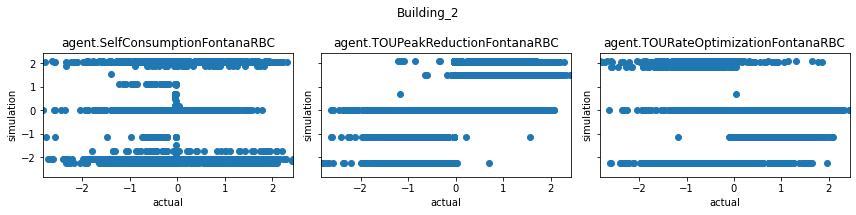

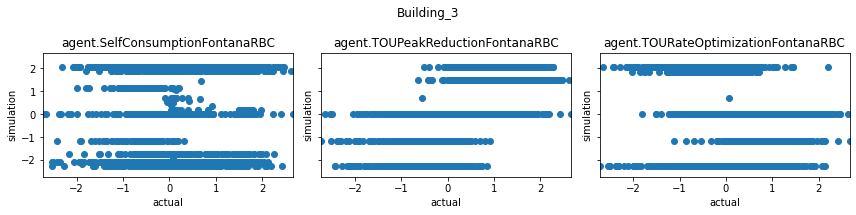

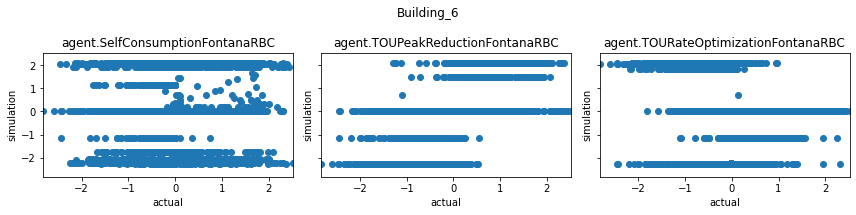

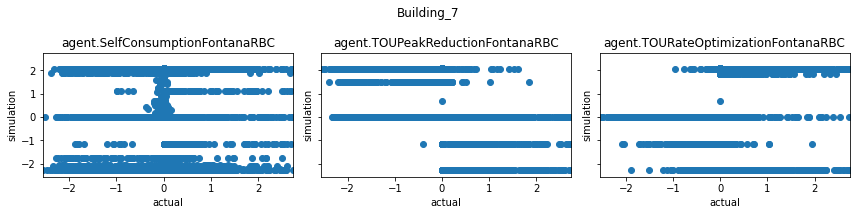

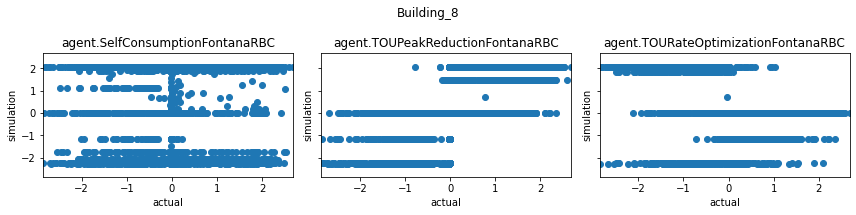

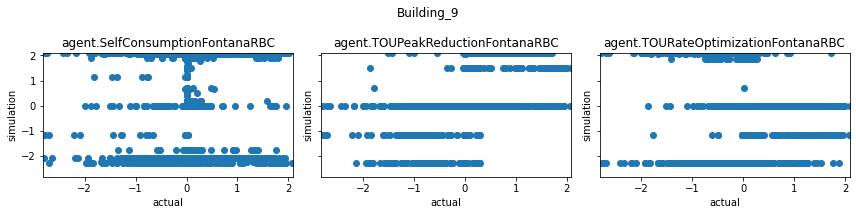

In [106]:
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,3*row_count),sharex=True,sharey=True)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['actual_electrical_storage_electricity_consumption'] 
        y = rbc_data['simulation_electrical_storage_net_electricity_consumption']
        lim = (min(x.min(),y.min()), max(x.max(),y.max()))
        ax.scatter(x,y)
        ax.set_xlabel('actual')
        ax.set_ylabel('simulation')
        ax.set_title(rbc_type)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

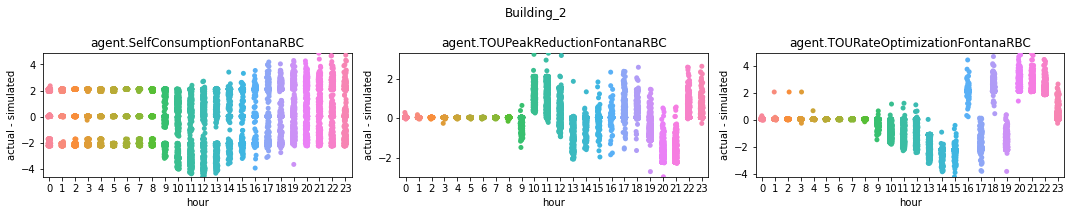

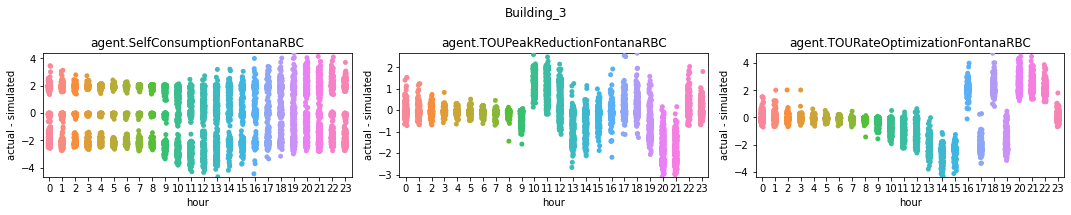

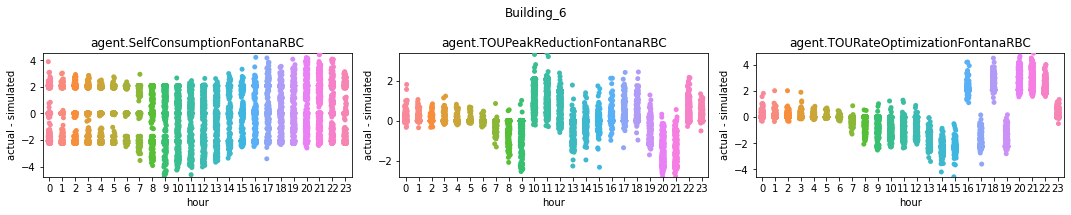

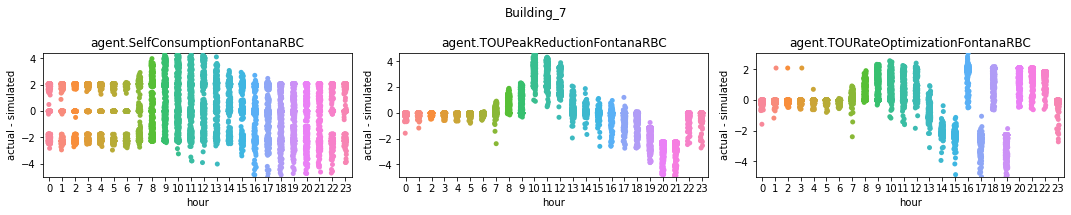

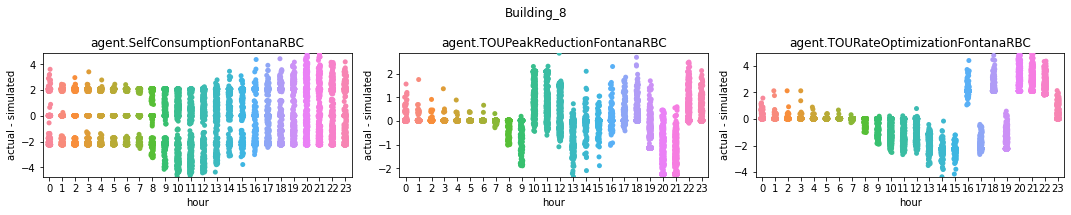

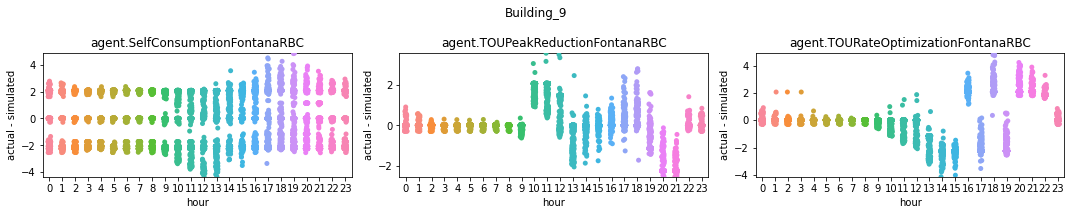

In [114]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        sns.stripplot(x='hour',y='error',data=rbc_data,ax=ax)
        ax.set_xlabel('hour')
        ax.set_ylabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

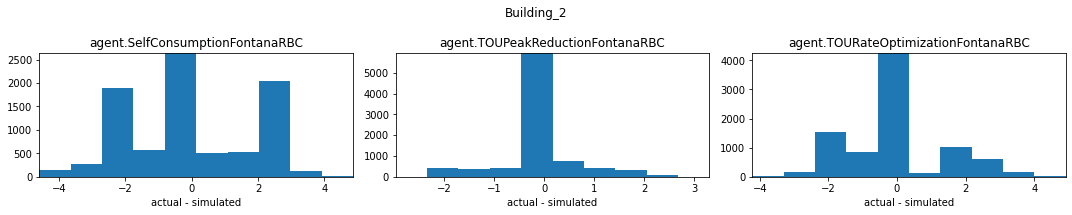

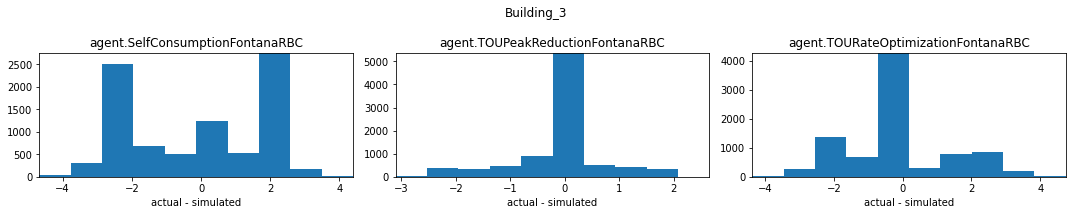

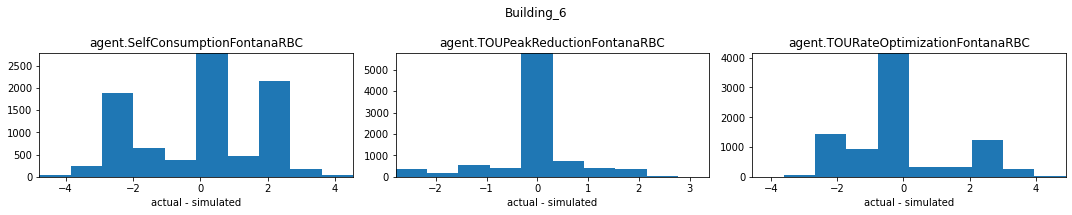

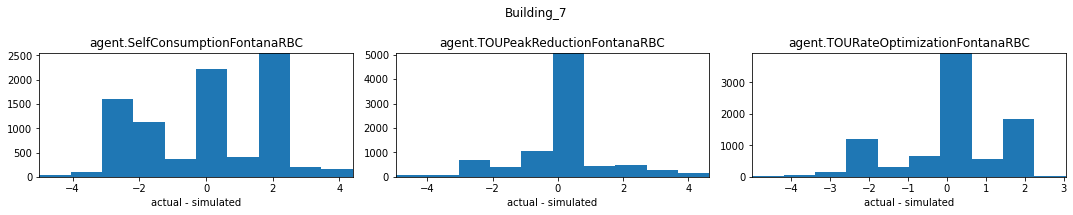

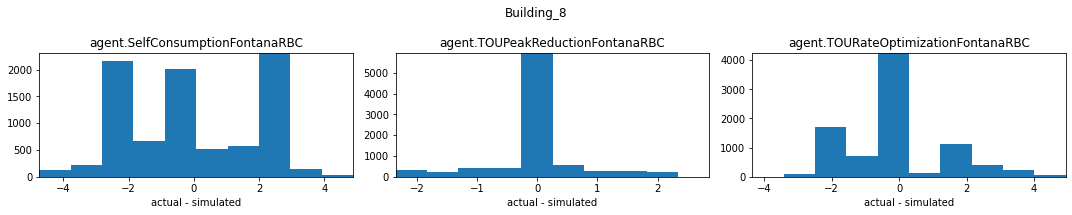

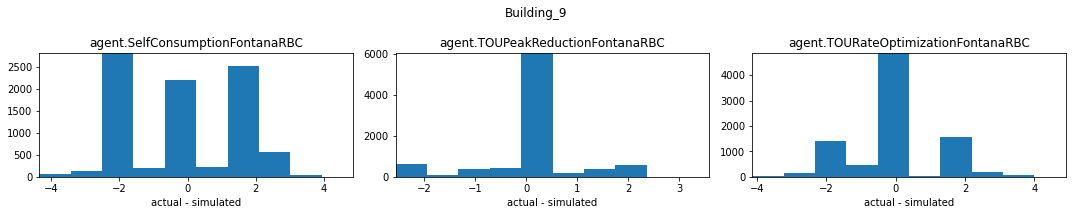

In [144]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['error']
        ax.hist(x)
        ax.set_xlabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

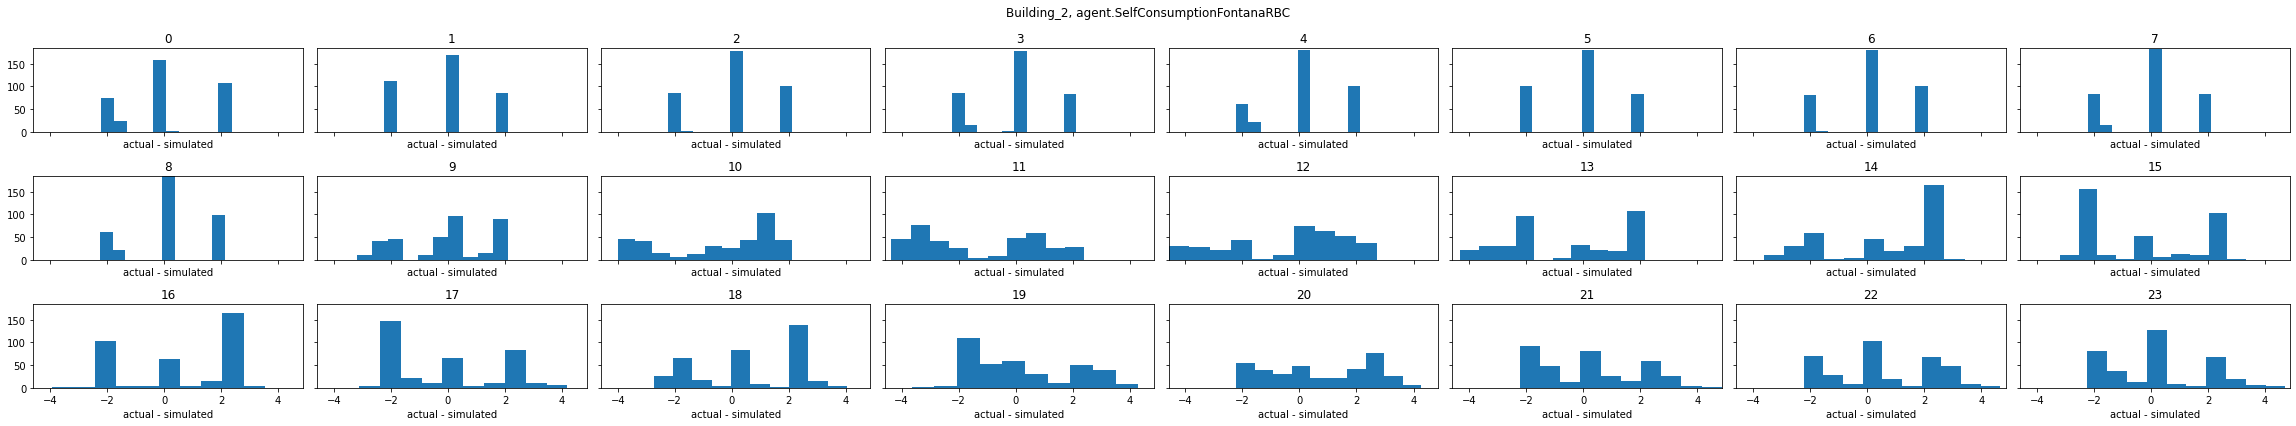

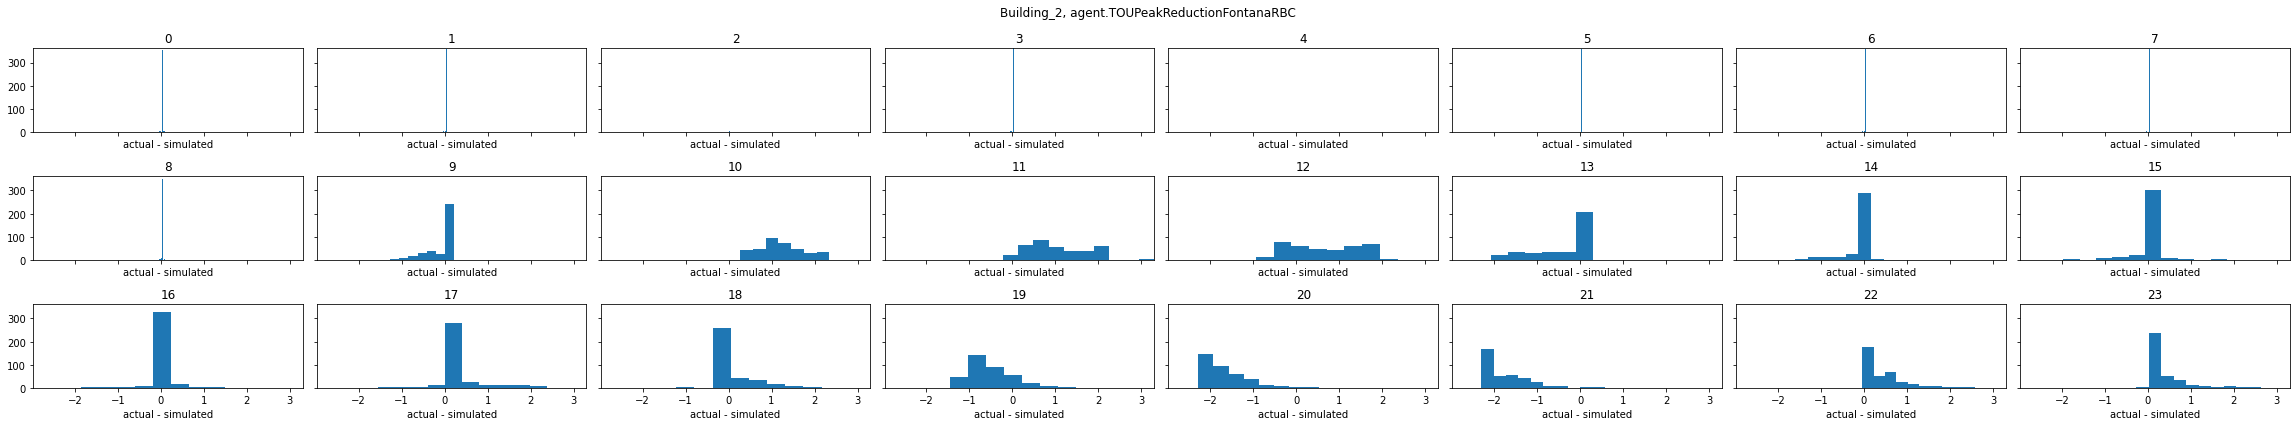

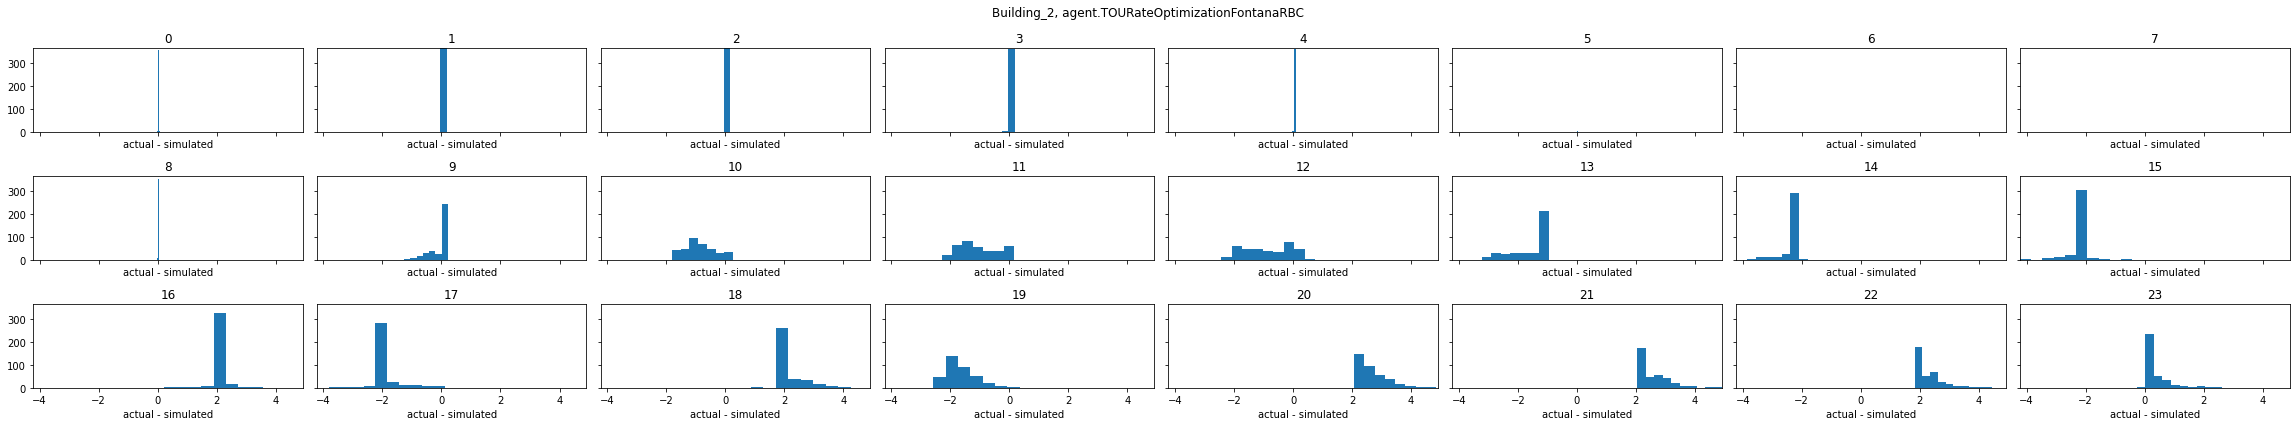

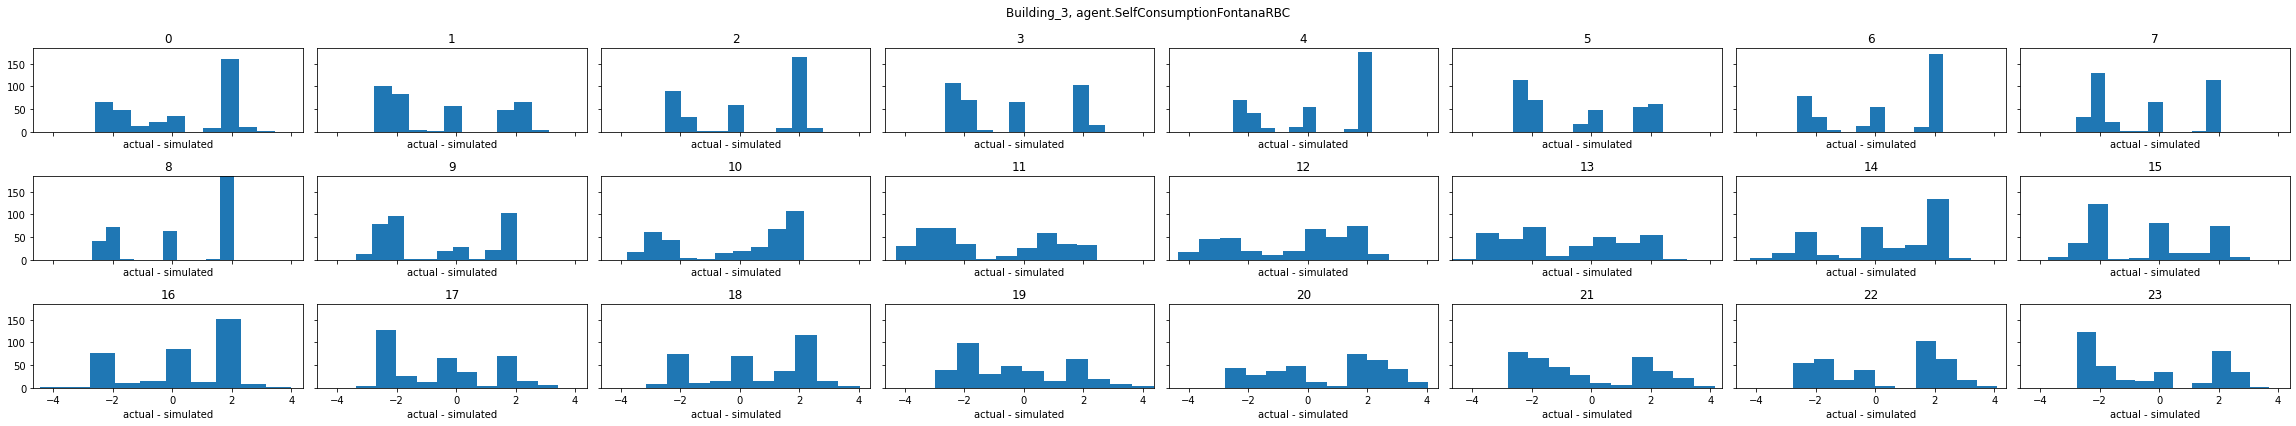

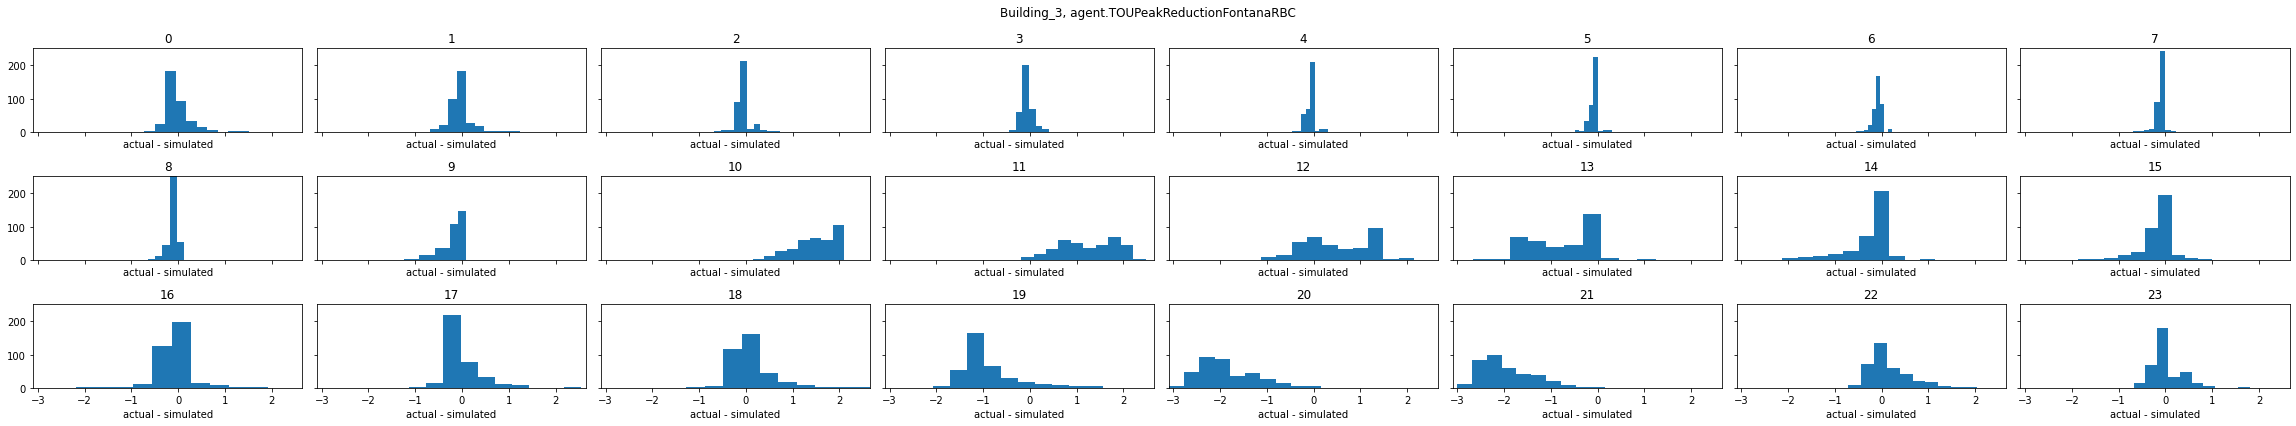

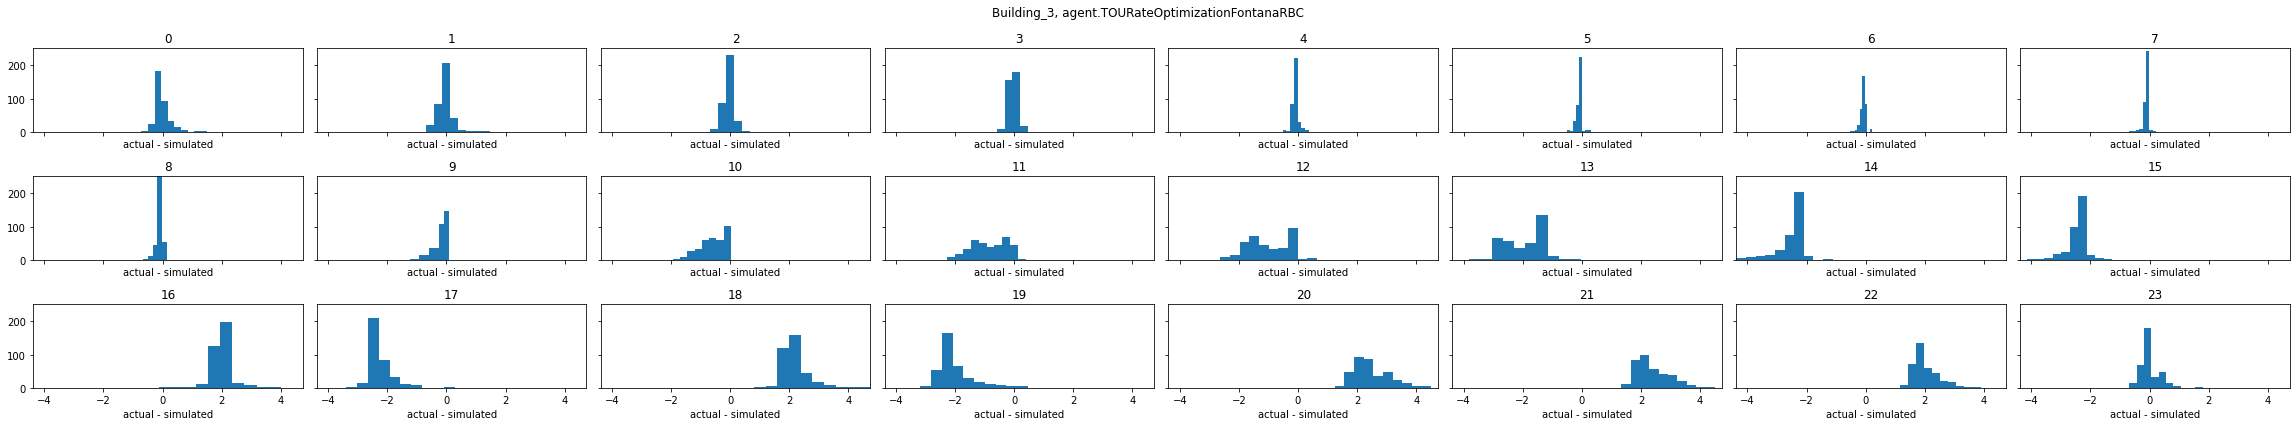

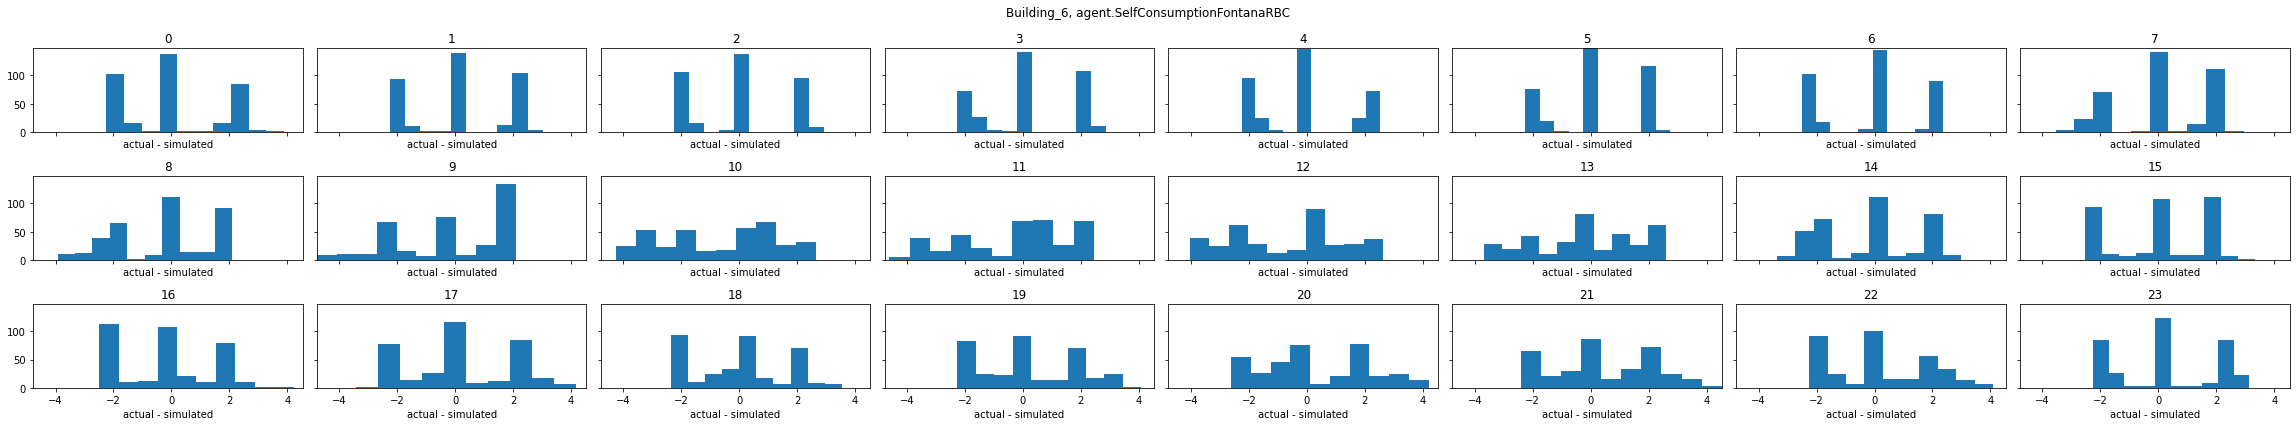

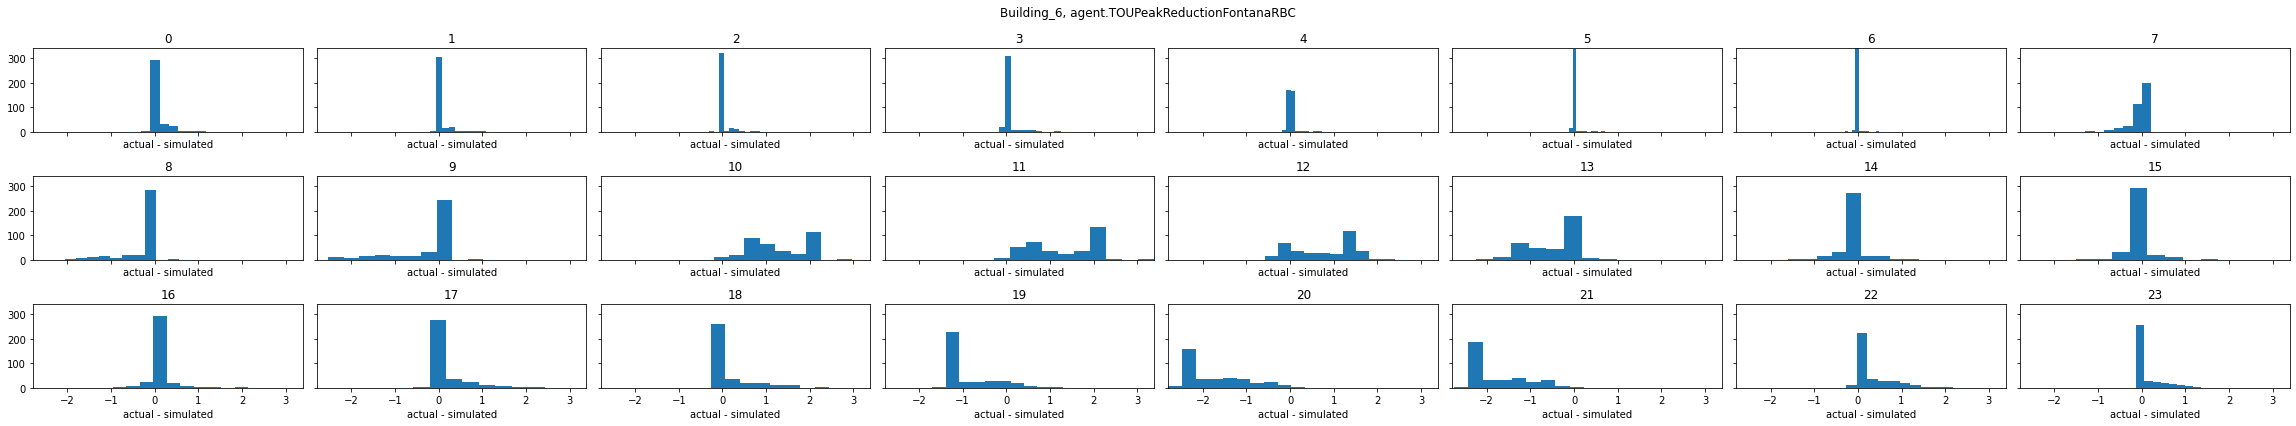

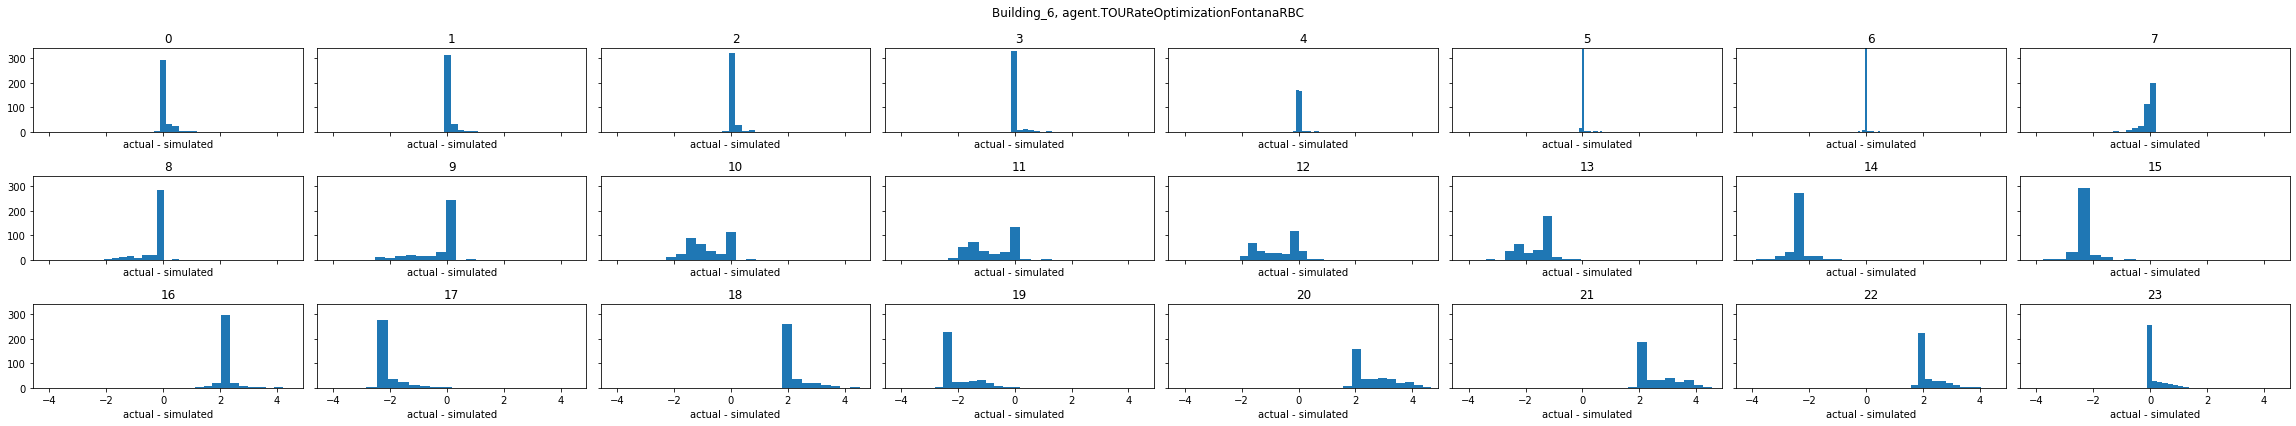

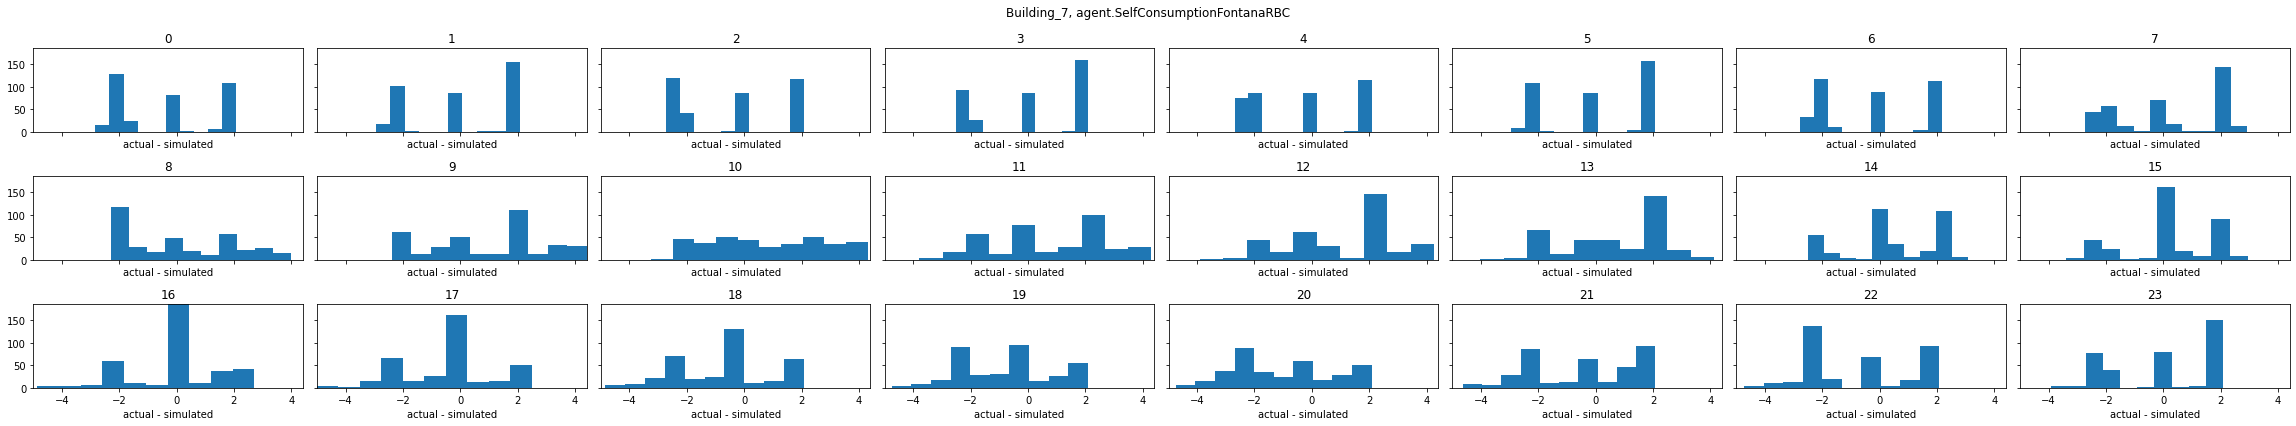

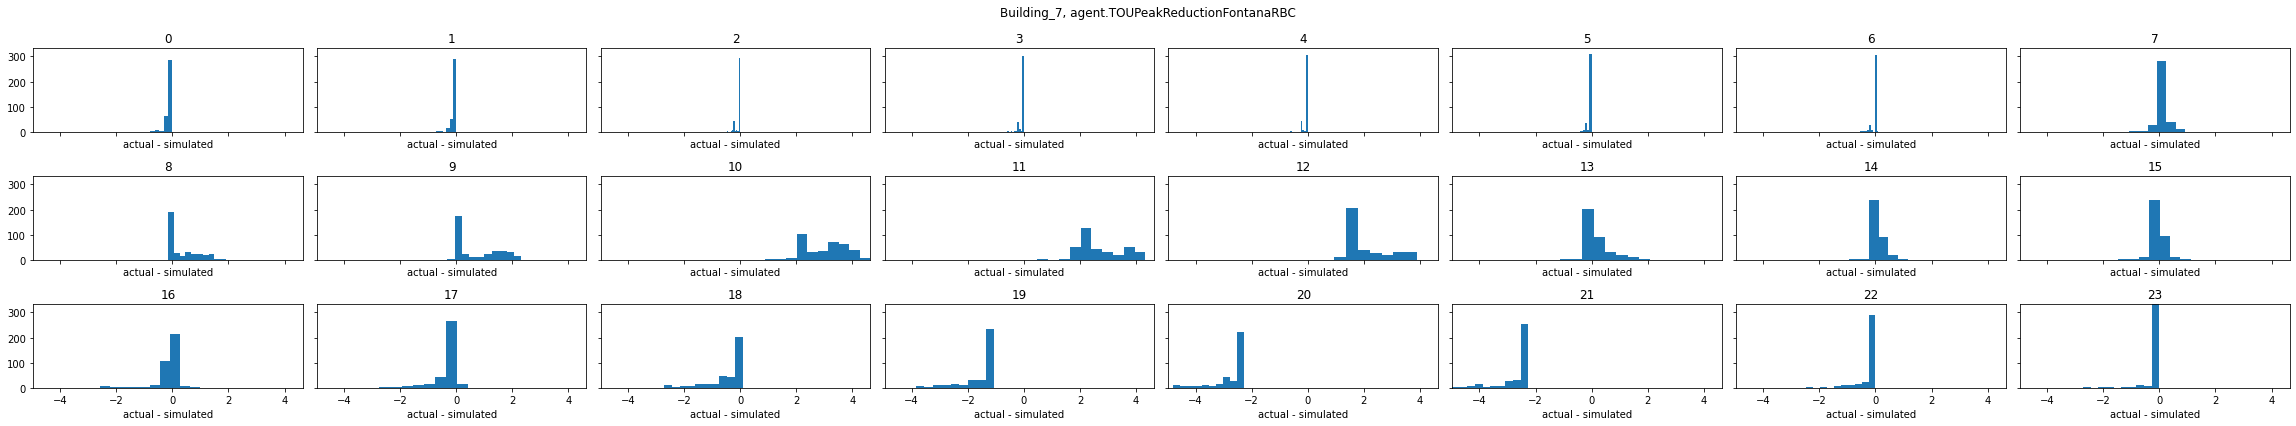

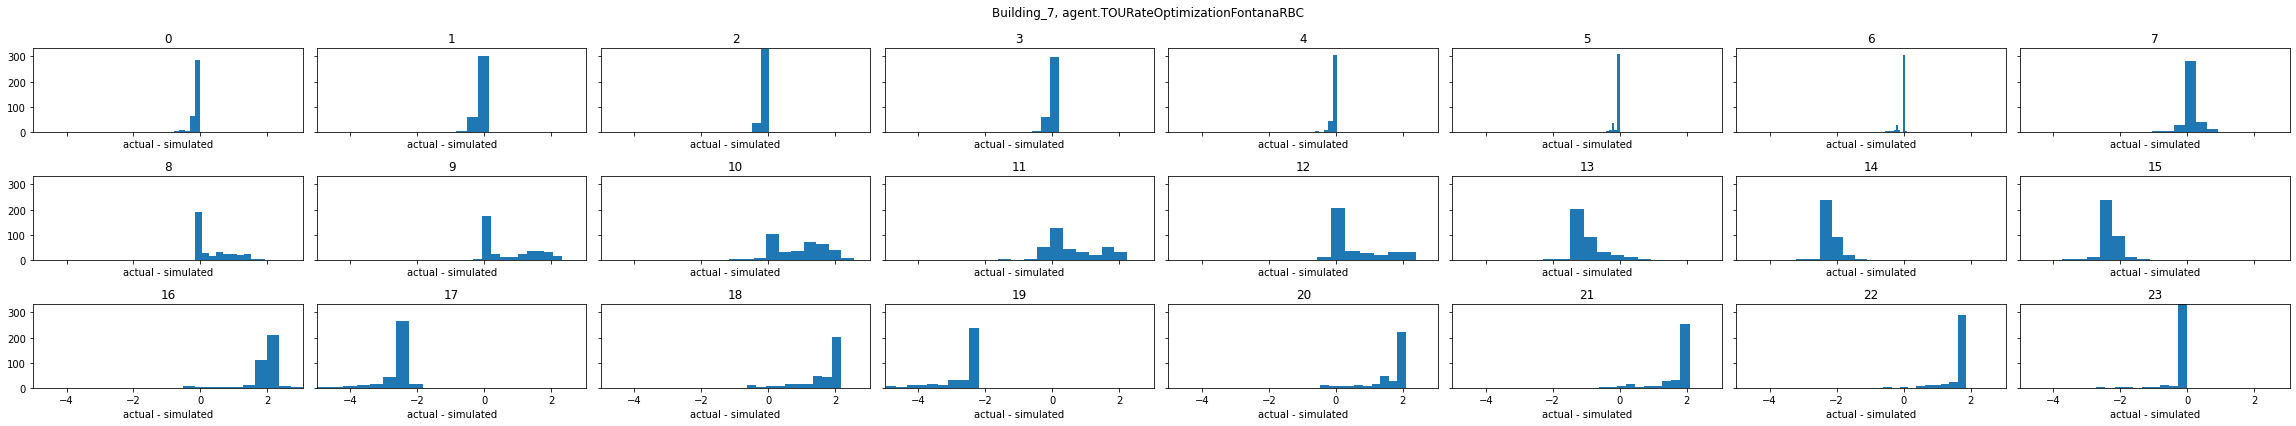

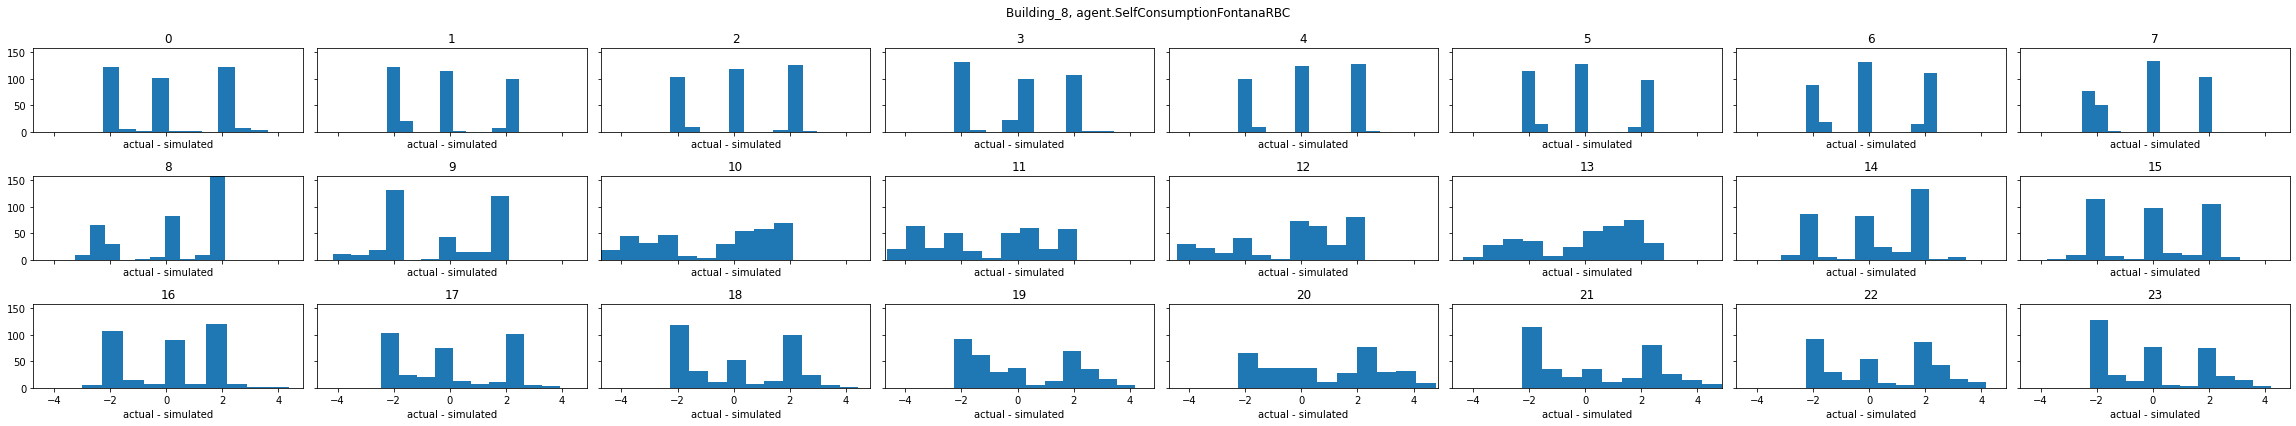

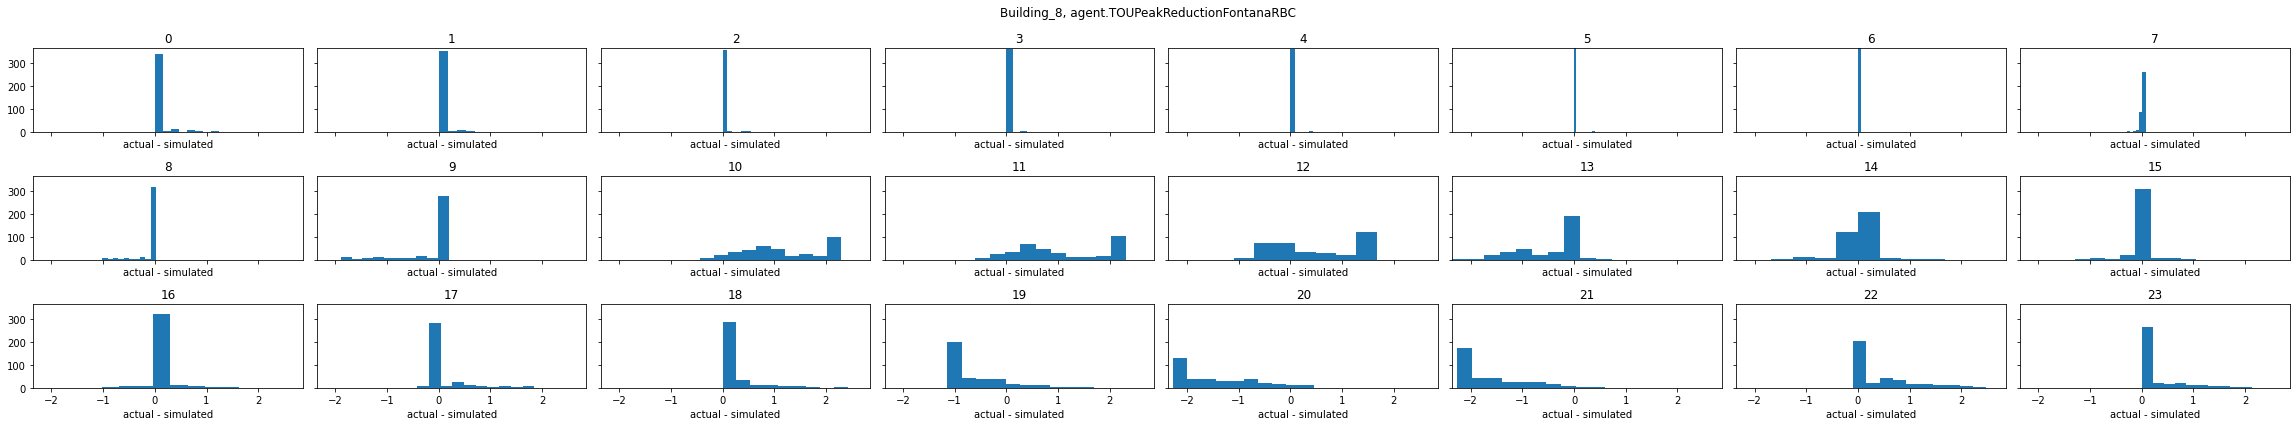

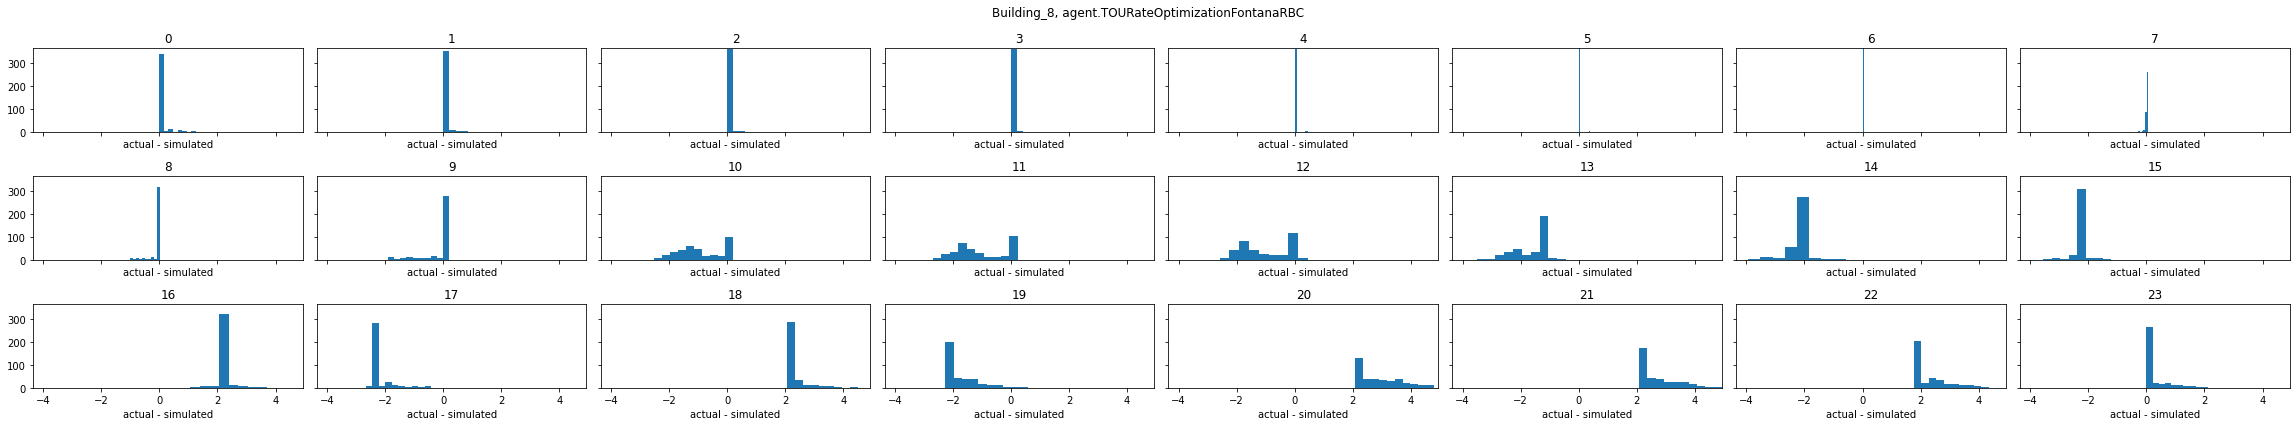

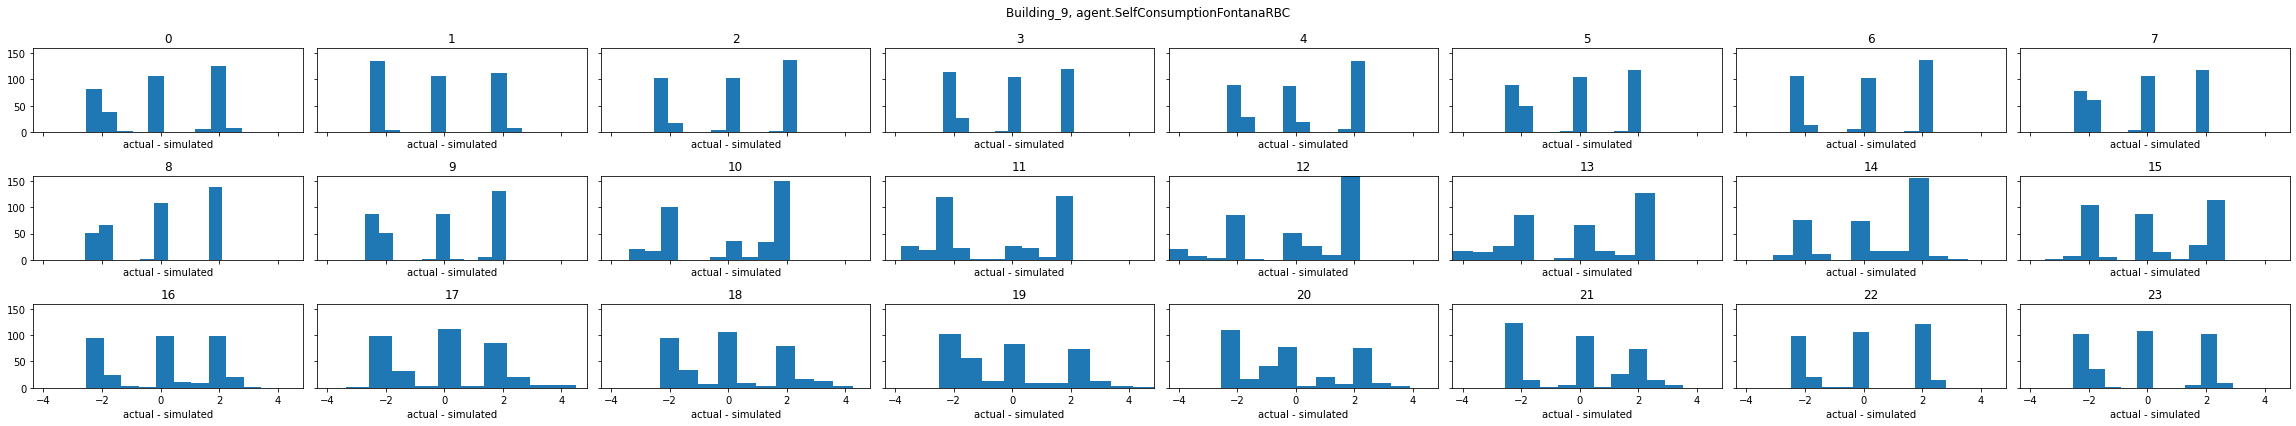

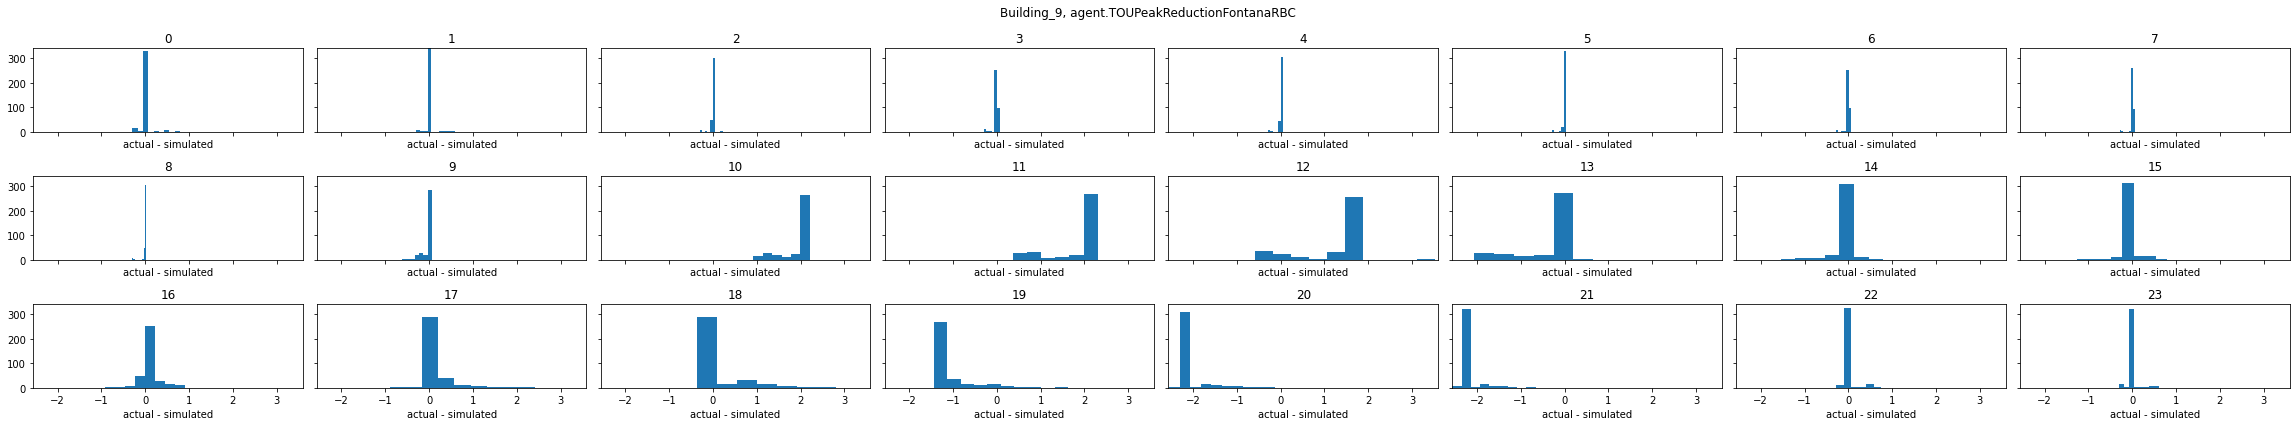

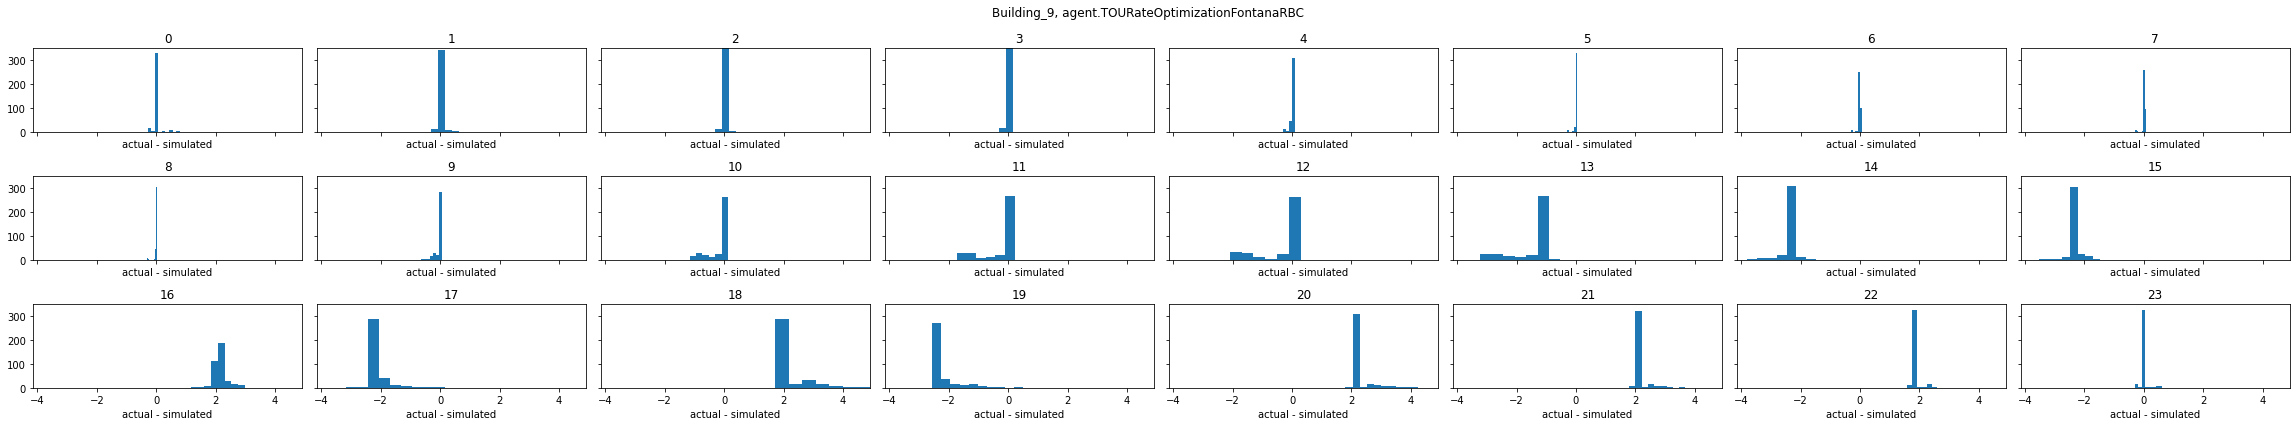

In [131]:
# how are the errors distributed hourly in a histogram?
column_count_limit = 8
hour_count = len(rbc_validation_simulations['hour'].unique())

for building, building_data in rbc_validation_simulations.groupby('building_id'):
    
    for rbc_type, rbc_data in building_data.groupby('type'):
        row_count = math.ceil(hour_count/column_count_limit)
        column_count = min(hour_count,column_count_limit)
        fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,2*row_count),sharey=True,sharex=True)

        for ax, (hour, hour_data) in zip(fig.axes,rbc_data.groupby('hour')):
            x = hour_data['error']
            ax.hist(x,bins=10)
            ax.set_xlabel('actual - simulated')
            ax.set_title(hour)
    
        fig.suptitle(f'{building}, {rbc_type}')
        plt.tight_layout()
        plt.show()
    
    # assert False

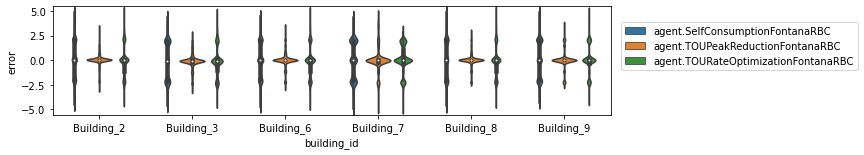

building_id                                 type     error            \
                                                          min       max   
0   Building_2      agent.SelfConsumptionFontanaRBC  0.001650  4.861753   
1   Building_2     agent.TOUPeakReductionFontanaRBC  0.000233  3.298010   
2   Building_2  agent.TOURateOptimizationFontanaRBC  0.000233  4.913941   
3   Building_3      agent.SelfConsumptionFontanaRBC  0.000167  4.672133   
4   Building_3     agent.TOUPeakReductionFontanaRBC  0.000017  3.101256   
5   Building_3  agent.TOURateOptimizationFontanaRBC  0.000017  4.739191   
6   Building_6      agent.SelfConsumptionFontanaRBC  0.000000  4.775136   
7   Building_6     agent.TOUPeakReductionFontanaRBC  0.000000  3.386477   
8   Building_6  agent.TOURateOptimizationFontanaRBC  0.000000  4.904248   
9   Building_7      agent.SelfConsumptionFontanaRBC  0.000000  4.994474   
10  Building_7     agent.TOUPeakReductionFontanaRBC  0.000000  4.964274   
11  Building_7  agent.TOURateOptimizationFontanaRBC  0.000000  4.998356   
12  Building_8      agent.SelfConsumptionFontanaRBC  0.000000  4.873047   
13  Building_8     agent.TOUPeakReductionFontanaRBC  0.000000  2.859277   
14  Building_8  agent.TOURateOptimizationFontanaRBC  0.000000  4.931451   
15  Building_9      agent.SelfConsumptionFontanaRBC  0.000000  4.856503   
16  Building_9     agent.TOUPeakReductionFontanaRBC  0.000000  3.592360   
17  Building_9  agent.TOURateOptimizationFontanaRBC  0.000000  4.902077   

                        
        mean       std  
0   1.438909  1.066928  
1   0.409936  0.631760  
2   1.061169  1.081623  
3   1.725916  0.868908  
4   0.506910  0.667566  
5   1.088785  1.060664  
6   1.389011  1.038571  
7   0.443248  0.685568  
8   1.061734  1.096048  
9   1.556937  1.018017  
10  0.754048  1.114251  
11  0.969708  1.002680  
12  1.591386  1.019862  
13  0.396447  0.647852  
14  1.090658  1.134444  
15  1.543338  0.951925  
16  0.484915  0.800188  
17  0.920427  1.054663

In [148]:
# error summary
rbc_validation_error_summary = rbc_validation_simulations.copy()
rbc_validation_error_summary['error'] = rbc_validation_error_summary['error'].abs()
rbc_validation_error_summary = rbc_validation_error_summary.groupby(['building_id','type'])[['error']].agg([min,max,'mean','std']).reset_index()
fig, ax = plt.subplots(1,1,figsize=(10,2))
sns.violinplot(x='building_id',y='error',data=rbc_validation_simulations,hue='type')
ax.legend(ncol=1,bbox_to_anchor= (1.01,0.9))
plt.show()

display(rbc_validation_error_summary)

# Hyperparameter Design

In [153]:
hyperparameter_design_grid_filepath = os.path.join(misc_directory,'hyperparameter_design_grid.csv')
hyperparameter_design_grid = pd.read_csv(hyperparameter_design_grid_filepath)
completed_simulations = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
episodes = 10

# read data
hyperparameter_design_simulations = []


for simulation_id in completed_simulations:
    for episode in range(episodes):
        filepath = os.path.join(result_directory,f'hyperparameter_design_{simulation_id}_episode_{episode}.pkl')
        
        with (open(filepath, 'rb')) as openfile:
            env = pickle.load(openfile)

        cost, carbon_emission = env.evaluate()
        record = {
            'simulation_id':f'hyperparameter_design_{simulation_id}',
            'episode':episode,
            'cost':cost,
            'carbon_emission':carbon_emission,
            'average':(cost + carbon_emission)/2
        }
        hyperparameter_design_simulations.append(record)

hyperparameter_design_simulations = pd.DataFrame(hyperparameter_design_simulations)
hyperparameter_design_simulations = hyperparameter_design_simulations.merge(hyperparameter_design_grid,on='simulation_id',how='inner')

# ordered  results
hyperparameter_design_simulations = hyperparameter_design_simulations.sort_values('average')
display(hyperparameter_design_simulations[hyperparameter_design_simulations['episode']==9])

,average,carbon_emission,cost,episode,simulation_id,discount,tau,lr,buildings
249,0.992144,1.017977,0.966311,9,hyperparameter_design_24,0.99,0.0500,0.0005,"[1, 13, 14]"
129,0.993943,1.028333,0.959552,9,hyperparameter_design_12,0.95,0.0050,0.0005,"[1, 13, 14]"
219,0.995286,1.063979,0.926593,9,hyperparameter_design_21,0.99,0.0050,0.0005,"[1, 13, 14]"
109,1.002410,1.003392,1.001429,9,hyperparameter_design_10,0.95,0.0005,0.0050,"[1, 13, 14]"
269,1.004804,1.007579,1.002028,9,hyperparameter_design_26,0.99,0.0500,0.0500,"[1, 13, 14]"
239,1.006002,1.009472,1.002532,9,hyperparameter_design_23,0.99,0.0050,0.0500,"[1, 13, 14]"
199,1.006788,1.012185,1.001391,9,hyperparameter_design_19,0.99,0.0005,0.0050,"[1, 13, 14]"
119,1.006908,1.010616,1.003200,9,hyperparameter_design_11,0.95,0.0005,0.0500,"[1, 13, 14]"
29,1.007090,1.010929,1.003252,9,hyperparameter_design_2,0.90,0.0005,0.0500,"[1, 13, 14]"
209,1.007640,1.012487,1.002792,9,hyperparameter_design_20,0.99,0.0005,0.0500,"[1, 13, 14]"
